In [451]:
import os
import pandas as pd
import numpy as np
import matplotlib as mp
import scipy as sp
import csv
import math as math
import matplotlib.pyplot as plt
import datetime
from datetime import datetime, timedelta, time
from time import sleep
from dateutil.parser import parse
from sklearn.cluster import DBSCAN
from sklearn import metrics
from geopy.distance import great_circle
import geopy.distance


# read IOT dataset into pandas
IOTdf = pd.read_csv("Datathon_IOT_Data.csv",index_col=False)

### For the purposes of this assignment we decided to concentrate only on one user. Her name is Siti. We will build our prediction based on her past behaviour. Here we take only device C1 as an example assuming each device is driven by only a user

In [485]:
user='C1'

# We decide to take in only these fields, we are planning to do clustering based on location and time datapoints to learn 
# where Siti usually goes.
df= IOTdf[['Device PN','Locate time','Locate Status', 'Altitude', 'Longitude', 'Latitude' ]]
# Only take in rows with geographic points
df=df.loc[df['Locate Status'] == 1]
df=df.rename(columns={'Altitude': "alt", "Longitude": "lng",  "Latitude": "lat", 'Locate time': "time"})
df=df.loc[df['Device PN'] == user]
# Index by time
df = df.set_index(pd.DatetimeIndex(df['time']))
df = df.drop(['Device PN', 'time','Locate Status'], axis=1)

not scaled


<module 'matplotlib.pyplot' from 'C:\\Users\\cs.phung\\AppData\\Roaming\\Python\\Python36\\site-packages\\matplotlib\\pyplot.py'>

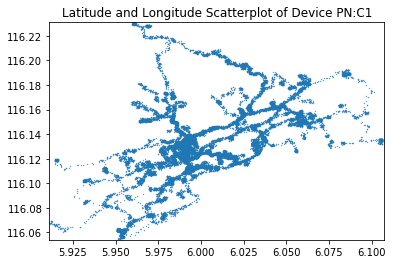

In [486]:
#Plot the locations to see what we are dealing with:
def locscatter(df,user,scaled=True):
    #plt.scatter(df['lng'],df['lat'],s=0.1)
    plt.scatter(df['lat'],df['lng'],s=0.1)
    plt.title('Latitude and Longitude Scatterplot of Device PN:'+user)
    if scaled:
        print ('scaled')
        medlat = df['lat'].median()
        stdlat = df['lat'].std()
        medlng = df['lng'].median()
        stdlng = df['lng'].std()
        plt.ylim([medlng-1*stdlng,medlng+1*stdlng]);
        plt.xlim([medlat-1*stdlat,medlat+1*stdlat])
    else:
        print ('not scaled')
        plt.xlim([df['lat'].min(),df['lat'].max()])
        plt.ylim([df['lng'].min(),df['lng'].max()])
    return plt

#locscatter(df,user,True)
locscatter(df,user,False)

###   Plots the median, mean, and standard deviation as a histogram at different times of the day  of [lat, long] in binned 1hr timeslots to visually find home or work place of Siti based on the standard deviation of mean and median. If standard deviation is low, means Siti is at home or at work

In [487]:

def timeofdayhist(df,var):   
    std = []
    median = []
    mean = []
    validtimes = []
    for t in range(24):
        npoints = len(df.between_time(time(t),time(t,59,59)))
        if npoints > 24:
            validtimes.append(t)
            std.append(df.between_time(time(t),time(t,59,59))[var].std())
            median.append(df.between_time(time(t),time(t,59,59))[var].median())
            mean.append(df.between_time(time(t),time(t,59,59))[var].mean())

    maxmm = max(max(median),max(mean))
    minmm = min(min(median),min(mean))
    maxbuf = maxmm+(maxmm-minmm)/5.
    minbuf = minmm-(maxmm-minmm)/5.
    fig = plt.figure()
    ax = fig.add_subplot(111)
    N = len(validtimes)

    ## necessary variables
    ind = np.array(validtimes)                # the x locations for the groups
    width = 0.35                      # the width of the bars

    ## the bars
    rects1 = ax.bar(ind, median, width,
                    color='black',yerr=std,
                    error_kw=dict(elinewidth=2,ecolor='red'))

    rects2 = ax.bar(ind+width, mean, width,
                    color='red',
                    yerr=std,
                    error_kw=dict(elinewidth=2,ecolor='black'))

    # axes and labels
    ax.set_xlim(-width,len(ind)+width)
    ax.set_ylim(minbuf,maxbuf)
    ax.set_ylabel(var)
    ax.set_title('User: '+str(user)+' Average '+var+' vs. Time')
    xTickMarks = ['T'+str(i) for i in range(1,25,1)]
    ax.set_xticks(ind+width)
    xtickNames = ax.set_xticklabels(xTickMarks)
    plt.setp(xtickNames, rotation=45, fontsize=10)

    ## add a legend
    ax.legend( (rects1[0], rects2[0]), ('Median', 'Mean') )

    plt.show()
    return None

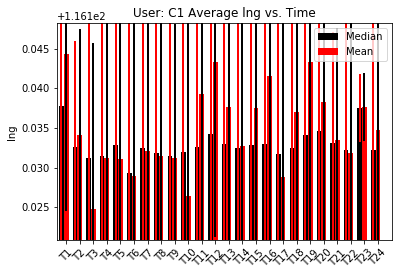

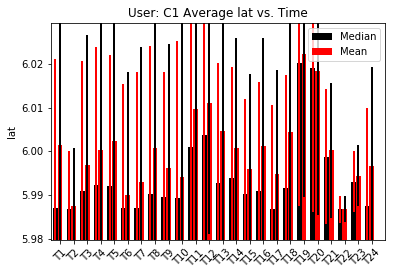

In [488]:
timeofdayhist(df,'lng')
timeofdayhist(df,'lat')

### Assesment of the time binned histograms above:
We could not find the location of home or work as the standard deviation (red & black lines) for each hour  is quite large.
Siti seems to have interesting sleeping pattern as she does not sleep at fixed time, ie. standard deviation for each hour  is quite large.

## DBSCAN clustering model to locate high point density area:
Benefit of DBSCAN being number of clusters are not needed as input to the model as compared to method such as K-means. 

In [537]:
def dbcluster(eps,min_samples,X,scale):

    from sklearn.cluster import DBSCAN
    from sklearn import metrics
    from sklearn.datasets.samples_generator import make_blobs
    from sklearn.preprocessing import StandardScaler

    
    if scale:
        X = StandardScaler().fit_transform(X)
    
    ##############################################################################
    # Compute DBSCAN
    db = DBSCAN(eps, min_samples).fit(X)
    core_samples = db.core_sample_indices_
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    
    print('Estimated number of clusters: %d' % n_clusters_)
    print("Silhouette Coefficient: %0.3f"
          % metrics.silhouette_score(X, labels))
    
    ##############################################################################
    # Plot result
    import pylab as pl
    
    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = pl.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = 'k'
            markersize = 1
        class_members = [index[0] for index in np.argwhere(labels == k)]
        cluster_core_samples = [index for index in core_samples
                                if labels[index] == k]
        for index in class_members:
            x = X[index]
            if index in core_samples and k != -1:
                markersize = 4
                pl.plot(x[0], x[1], 'o', markerfacecolor=col,
                        markeredgecolor='k', markersize=markersize)
            else:
                markersize = 1

    pl.title('Estimated number of clusters: %d' % n_clusters_)
    pl.show()
    return labels , unique_labels, core_samples

User: C1
Estimated number of clusters: 20
Silhouette Coefficient: 0.078


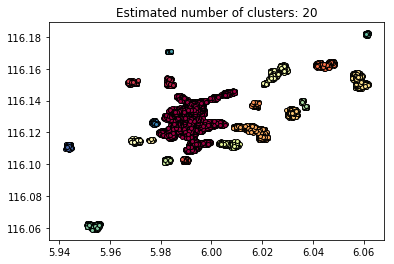

In [538]:
print ('User:',user)
df1 = np.array([df['lat'].values,df['lng'].values]).T
# Hardcoded 0.0025 is the eps which is the maximum distance between two samples for them to be 
# considered as in the same neighborhood which will determine the noise to be filtered. Hardcoded 100 is 
# the number of samples  in a neighborhood for a point to be considered as a core point. In order to find optimal paramaters
# we would need to 'grid search' the parameters
labels,unique_labels, core_samples =dbcluster(0.0025,  200, df1,False)


### Siti is a person and does not go to just a location. We need to link clusters to points of interest. First, we find the centroids of clusters

In [493]:
X= np.c_[df1,labels]
clusters=[]
for i in range(0,len(unique_labels)-1):
    print ('Location of Cluster', str(i),": [", X[X[:,2]==i][:,0].mean(0),',', X[X[:,2]==i][:,1].mean(0),']')
    clusters.append([X[X[:,2]==i][:,0].mean(0),  X[X[:,2]==i][:,1].mean(0)])

Location of Cluster 0 : [ 5.9902223093391695 , 116.13010264570151 ]
Location of Cluster 1 : [ 5.983547818532818 , 116.15176942084942 ]
Location of Cluster 2 : [ 5.9685522300469485 , 116.15141570422534 ]
Location of Cluster 3 : [ 5.989527176470587 , 116.10277992156865 ]
Location of Cluster 4 : [ 6.044692645631068 , 116.16262944174755 ]
Location of Cluster 5 : [ 6.017453615819209 , 116.137307259887 ]
Location of Cluster 6 : [ 6.016888315252074 , 116.12078809827696 ]
Location of Cluster 7 : [ 6.031753445026178 , 116.13200393717278 ]
Location of Cluster 8 : [ 6.0581332524708005 , 116.15239999101527 ]
Location of Cluster 9 : [ 5.976125931558936 , 116.11519281368821 ]
Location of Cluster 10 : [ 5.969335237020315 , 116.11477911963883 ]
Location of Cluster 11 : [ 6.025133530844156 , 116.15653457792209 ]
Location of Cluster 12 : [ 6.00749992481203 , 116.1126567067669 ]
Location of Cluster 13 : [ 5.982298 , 116.10222946666666 ]
Location of Cluster 14 : [ 6.036362708333335 , 116.13805488425926 ]


### We need find points of interest around these centroids. To do this we are using geopy to calculate distance between our centroids and the point of interests. Geopy implement a more accurate ellipsoidal models such as WGS-84.

In [494]:
#create new df 
df2= pd.DataFrame(clusters)
df2=df2.rename(columns={0: "lat", 1: "lng"})
# read point of interest dataset into pandas
dfPOI = pd.read_csv("Datathon_Trip_POI.csv",index_col=False)
dfPOI=dfPOI.rename(columns={'long': "lng"})

## Identify points of interest that are near the centroids of the clusters

In [495]:
delta=1 # Within 1 km boundary. Can be modified to change how far from the centroid the boundary should be. 
# Could be not optimal when the list of points of interest becomes large
recomendation=[]
for i in range(0,len(df2)):
    location_recommendation=[]
    for j in range(0,len(dfPOI)):
        coords_1 =(df2.iloc[i,0], df2.iloc[i,1])
        coords_2 =(dfPOI.iloc[j,4], dfPOI.iloc[j,3])
        if geopy.distance.vincenty(coords_1, coords_2)<delta:
            location_recommendation.append([dfPOI.iloc[j,0],dfPOI.iloc[j,1], dfPOI.iloc[j,2] ])
    recomendation.append(location_recommendation)

In [496]:
print("Places near the centres of clusters:")
for i in range(0,len(recomendation)):
    print ("Cluster", i)
    if len(recomendation[i])>0:
        for j in range (0, len(recomendation[i])):
            print (str(j), 'poi_id: ', recomendation[i][j][0], ', category: ', recomendation[i][j][1], ', name: ', recomendation[i][j][2])
    else:
        print('No POI found within the range')

Places near the centres of clusters:
Cluster 0
0 poi_id:  1006 , category:  Petrol_station , name:  Petronas Inanam
1 poi_id:  5955 , category:  Convenience_store , name:  Asian Mini Mart
2 poi_id:  7384 , category:  Convenience_store , name:  Giant Hypermarket Kolombong
3 poi_id:  15636 , category:  Cafe , name:  My Kopitiam
4 poi_id:  9476 , category:  Bank , name:  Public Bank
5 poi_id:  7375 , category:  Convenience_store , name:  Giant Kolombong
6 poi_id:  9470 , category:  Bank , name:  CIMB Bank
7 poi_id:  8328 , category:  Electronics_store , name:  SenHeng Electrical (KL) Sdn. Bhd.
8 poi_id:  5933 , category:  Convenience_store , name:  7-eleven @ Inanam Business Centre, Inanam
9 poi_id:  17077 , category:  Pet_store , name:  Lim Veterinary Supplies
10 poi_id:  9488 , category:  Bank , name:  Bank Simpanan Nasional @ Inanam
11 poi_id:  3518 , category:  Petrol_station , name:  Shell Inanam
12 poi_id:  8319 , category:  Electronics_store , name:  Senheng
13 poi_id:  11403 , cat

### Based on the results, we predict that user will most likely visit these places, we can then recommend these places to user. To make this recommendation useful we need to know time when Siti is going to travel. To do that we decided to use Hidden Markov Chain

In [509]:
df3 = df.reset_index()
df3['weekday'] = df3['time'].dt.dayofweek
df3['hour'] = df3['time'].dt.hour
df3.loc[(df3.hour >=1) & (df3.hour<=3) ,'weekday_interval'] = '1'
df3.loc[(df3.hour >=4) & (df3.hour<=6) ,'weekday_interval'] = '2'
df3.loc[(df3.hour >=7) & (df3.hour<=9) ,'weekday_interval'] = '3'
df3.loc[(df3.hour >=10) & (df3.hour<=12) ,'weekday_interval'] = '4'
df3.loc[(df3.hour >=13) & (df3.hour<=15) ,'weekday_interval'] = '5'
df3.loc[(df3.hour >=16) & (df3.hour<=18) ,'weekday_interval'] = '6'
df3.loc[(df3.hour >=19) & (df3.hour<=21) ,'weekday_interval'] = '7'
df3.loc[(df3.hour >=22) | (df3.hour==0) ,'weekday_interval'] = '8'
df3.loc[(df3.weekday==6) ,'weekday_str'] = 'Sun'
df3.loc[(df3.weekday==0) ,'weekday_str'] = 'Mon'
df3.loc[(df3.weekday==1) ,'weekday_str'] = 'Tue'
df3.loc[(df3.weekday==2) ,'weekday_str'] = 'Wed'
df3.loc[(df3.weekday==3) ,'weekday_str'] = 'Thu'
df3.loc[(df3.weekday==4) ,'weekday_str'] = 'Fri'
df3.loc[(df3.weekday==5) ,'weekday_str'] = 'Sat'
df3['Date']=df3['time'].dt.date.astype(str)
df3['Period'] = df3[['weekday_str', 'weekday_interval']].apply(lambda x: ''.join(x), axis=1)
df3.head()


,time,alt,lng,lat,weekday,hour,weekday_interval,weekday_str,Date,Period
0,2018-07-01 01:30:00,9,116.13279,5.98501,6,1,1,Sun,2018-07-01,Sun1
1,2018-07-01 01:31:00,8,116.13249,5.98635,6,1,1,Sun,2018-07-01,Sun1
2,2018-07-01 01:31:00,8,116.13139,5.98544,6,1,1,Sun,2018-07-01,Sun1
3,2018-07-01 01:32:00,6,116.13270,5.98704,6,1,1,Sun,2018-07-01,Sun1
4,2018-07-01 01:32:00,5,116.13183,5.98522,6,1,1,Sun,2018-07-01,Sun1


In [510]:
labelsdf=pd.DataFrame(labels, columns=['cluster_labels'])
X2= pd.concat([df3,labelsdf],axis=1)
X2 = X2.drop([ 'time','alt','lng', 'lat', 'weekday', 'hour', 'weekday_interval', 'weekday_str'], axis=1)
X2=X2.loc[X2['cluster_labels'] != -1] # remove noises
X2.head()

,Date,Period,cluster_labels
0,2018-07-01,Sun1,0
1,2018-07-01,Sun1,0
2,2018-07-01,Sun1,0
3,2018-07-01,Sun1,0
4,2018-07-01,Sun1,0


### Initial and Transition Probability

In [518]:
from collections import Counter
seq=X2.Date.values
Counter(seq).keys() # equals to list(set(words))
count=list(Counter(seq).values()) # counts the elements' frequency

In [519]:
cluster_labels=X2.cluster_labels.values
sequence=[]
Num_of_rows=0
for i in range (len(count)):
    a=[]
    a.append(cluster_labels[Num_of_rows])
    for j in range (Num_of_rows+1,Num_of_rows+count[i]):
        if cluster_labels[j]!=cluster_labels[j-1]:
            a.append(cluster_labels[j])
    sequence.append(a)
    Num_of_rows+=count[i]  

In [520]:
new_seq=[]
for i in range(len(sequence)):
    if(len(sequence[i])>1):
        new_seq.append(sequence[i])

In [521]:
len(new_seq)

33

In [522]:
### Initial Probability
initial=[0]*n_clusters_
ttl_int=0
for seq in new_seq:
    first=seq[0]
    initial[first]+=1
    ttl_int+=1
for i in range(n_clusters_):
    initial[i]=initial[i]/ttl_int
initial=np.array(initial)

In [523]:
### Transition Probability
n_clusters_=len(unique_labels)-1
print(n_clusters_)
transition =np.zeros(shape=(n_clusters_,n_clusters_))
for seq in new_seq:
    for i in range(len(seq)-1):
        transition[seq[i]][seq[i+1]]=(transition[seq[i]][seq[i+1]])+1

20


In [524]:
for i in range(n_clusters_):
    sumi=sum(transition[i][0:n_clusters_])
    for j in range(n_clusters_):
        transition[i][j]=(transition[i][j]*1.0)/sumi

### Emission Probability

In [525]:
Periods=['Mon1','Mon2', 'Mon3','Mon4', 'Mon5','Mon6', 'Mon7','Mon8',
        'Tue1','Tue2', 'Tue3','Tue4', 'Tue5','Tue6', 'Tue7','Tue8',
        'Wed1','Wed2', 'Wed3','Wed4', 'Wed5','Wed6', 'Wed7','Wed8',
        'Thu1','Thu2', 'Thu3','Thu4', 'Thu5','Thu6', 'Thu7','Thu8',
        'Fri1','Fri2', 'Fri3','Fri4', 'Fri5','Fri6', 'Fri7','Fri8',
        'Sat1','Sat2', 'Sat3','Sat4', 'Sat5','Sat6', 'Sat7','Sat8',
        'Sun1','Sun2', 'Sun3','Sun4', 'Sun5','Sun6', 'Sun7','Sun8'
       ]
emission=np.zeros(shape=(n_clusters_,len(Periods)))

In [526]:
for j in range(n_clusters_):
    datalen=X2.loc[X2.cluster_labels==j,:]
    for i,Period in enumerate(Periods):
        emission[j][i]=len(datalen.loc[datalen.Period==Period,:])

In [527]:
for i in range(n_clusters_):
    sumi=sum(emission[i][0:len(Periods)])
    for j in range(len(Periods)):
        emission[i][j]=(emission[i][j]*1.0)/sumi

In [544]:
obs=[]
obs_map = {}
for i in range(len(Periods)):
    obs.append(i)
    obs_map[Periods[i]]=i
obs=np.array(obs)

In [545]:
def viterbi(pi, a, b, obs):
    
    nStates = np.shape(b)[0]
    T = np.shape(obs)[0]
    # init blank path
    path = np.zeros(T)
    # delta --> highest probability of any path that reaches state i
    delta = np.zeros((nStates, T))
    # phi --> argmax by time step for each state
    phi = np.zeros((nStates, T))
    # init delta and phi 
    delta[:, 0] = pi * b[:, obs[0]]
    phi[:, 0] = 0

    #print('\nStart Walk Forward\n')    
    # the forward algorithm extension
    for t in range(1, T):
        for s in range(nStates):
            delta[s, t] = np.max(delta[:, t-1] * a[:, s]) * b[s, obs[t]] 
            phi[s, t] = np.argmax(delta[:, t-1] * a[:, s])
            #print('s={s} and t={t}: phi[{s}, {t}] = {phi}'.format(s=s, t=t, phi=phi[s, t]))
    
    # find optimal path
    #print('-'*50)
    #print('Start Backtrace\n')
    path[T-1] = np.argmax(delta[:, T-1])
    #p('init path\n    t={} path[{}-1]={}\n'.format(T-1, T, path[T-1]))
    for t in range(T-2, -1, -1):
        path[t] = phi[int(path[t+1]), [t+1]]
        #p(' '*4 + 't={t}, path[{t}+1]={path}, [{t}+1]={i}'.format(t=t, path=path[t+1], i=[t+1]))
        #print('path[{}] = {}'.format(t, path[t]))
        
    return path, delta, phi
#path, delta, phi = viterbi(initial, transition, emission, obs)
#print('\nsingle best state path: \n', path)
#print('delta:\n', delta)
#print('phi:\n', phi)

In [546]:
obs_new=obs[0:8]
path, delta, phi = viterbi(initial, transition, emission, obs_new)
#paths=[]
#for i in range(len(obs)):
#    path, delta, phi = viterbi(initial, transition, emission, np.array([obs[i]]))
#    paths.append((int(path[0]))

In [547]:
inv_obs_map = dict((v,k) for k, v in obs_map.items())
obs_seq = [inv_obs_map[v] for v in list(obs_new)]

### Predicting Monday Clusters Location and Time

In [548]:
state_map={}
for i in range(n_clusters_):
    state_map[i]='Cluster'+str(i)
state_path = [state_map[v] for v in path]

(pd.DataFrame()
 .assign(Observation=obs_seq)
 .assign(Cluster=state_path))

,Observation,Cluster
0,Mon1,Cluster0
1,Mon2,Cluster9
2,Mon3,Cluster0
3,Mon4,Cluster9
4,Mon5,Cluster0
5,Mon6,Cluster13
6,Mon7,Cluster0
7,Mon8,Cluster0
